In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score

plt.style.use("default")
sns.set_theme()

## Load Data

In [24]:
df = pd.read_csv("data/NYC_Inspection_data.csv")

## Basic info & missingness

In [25]:
print("Raw shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nPreview:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing value ratio per column:")
print(df.isna().mean().sort_values(ascending=False))

Raw shape: (103426, 26)

Columns:
 ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA']

Preview:
      CAMIS                   DBA           BORO BUILDING             STREET  \
0  41647571         PEKING GARDEN      Manhattan     3163           BROADWAY   
1  50128737           BAO BY KAYA      Manhattan      570   LEXINGTON AVENUE   
2  40510804         WOODROW DINER  Staten Island      655   ROSSVILLE AVENUE   
3  50077566        JANE FAST FOOD         Queens     8622           BROADWAY   
4  50110452  GREENHOUSE CAFE RBNY         Queens    10810  ROCKAWAY BEACH DR   

   ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0    10027  2128653600             Chinese        2/1/2022   
1   

## Basic Cleaning

In [26]:
# 1.1 Remove exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows.")

# 1.2 Convert date columns to datetime
date_cols = ["INSPECTION DATE", "GRADE DATE", "RECORD DATE"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# 1.3 Make ZIPCODE a string (to avoid losing leading zeros, and because it's categorical)
df["ZIPCODE"] = df["ZIPCODE"].astype(str)

# 1.4 Treat some columns as categorical
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE", "GRADE"]:
    df[col] = df[col].astype("category")

Dropped 0 duplicate rows.


## Handling Missing Data

In [27]:
before = df.shape[0]
df = df[~df["SCORE"].isna()]
after = df.shape[0]
print(f"Dropped {before - after} rows with missing SCORE.")

# Focus on grades A, B, C only (simplifies the classification problem)
valid_grades = ["A", "B", "C"]
before = df.shape[0]
df = df[df["GRADE"].isin(valid_grades)]
after = df.shape[0]
print(f"Dropped {before - after} rows with non A/B/C grades or missing grade.")

print("Shape after cleaning:", df.shape)

Dropped 50 rows with missing SCORE.
Dropped 19773 rows with non A/B/C grades or missing grade.
Shape after cleaning: (83603, 26)


## Simple Feature Transformation

In [28]:
# Extract year and month from INSPECTION DATE (useful for EDA and later modeling)
df["INSPECTION_YEAR"] = df["INSPECTION DATE"].dt.year
df["INSPECTION_MONTH"] = df["INSPECTION DATE"].dt.month

## Exploratory Data Analysis (EDA)


Grade counts:
GRADE
A         68421
B          9972
C          5210
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64


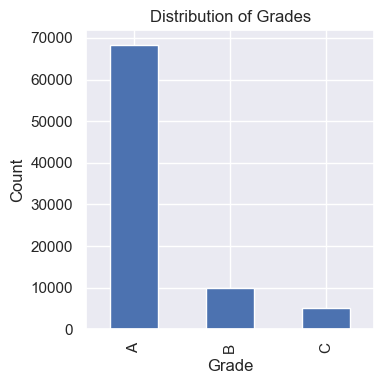

<Figure size 640x480 with 0 Axes>

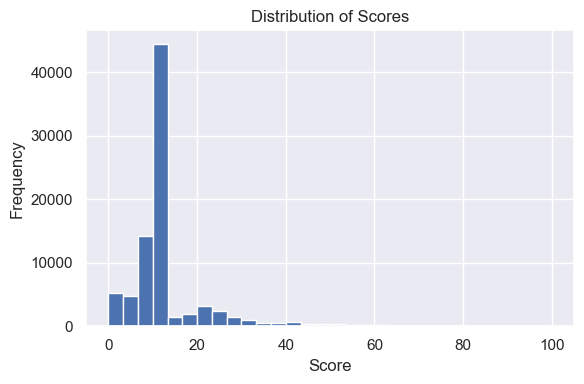


Grades by BORO:
GRADE              A     B     C
BORO                            
Bronx           5943  1020   472
Brooklyn       17929  2722  1456
Manhattan      25955  3366  1844
Queens         15828  2529  1329
Staten Island   2766   335   109


<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

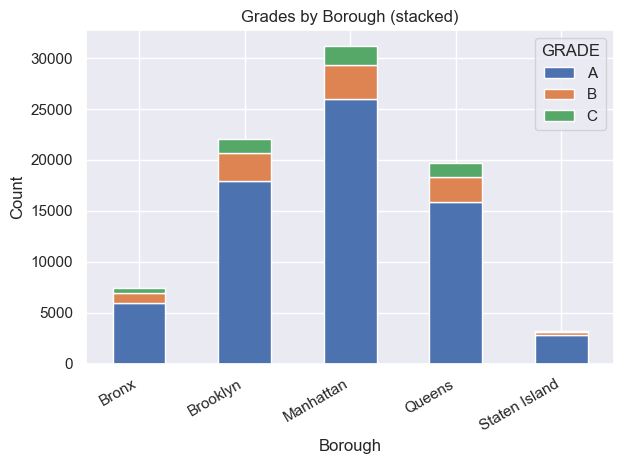


Top 10 cuisines:
CUISINE DESCRIPTION
American                    16028
Chinese                      7424
Coffee/Tea                   6131
Pizza                        5203
Italian                      3249
Bakery Products/Desserts     3101
Latin American               3048
Mexican                      2963
Japanese                     2741
Caribbean                    2618
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

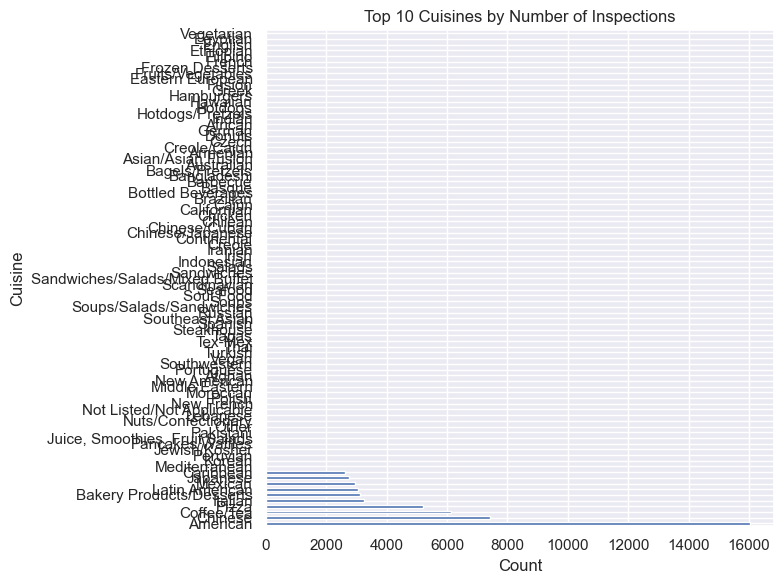

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

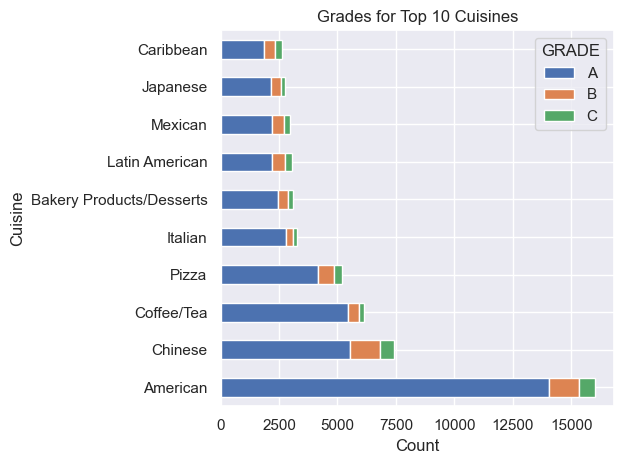


Average SCORE by year:
INSPECTION_YEAR
2012     7.000000
2013     2.500000
2015     8.000000
2016     9.719231
2017    10.506893
2018    11.560417
2019    12.689880
2020    12.378433
2021    12.305988
2022    13.243497
2023    13.889556
Name: SCORE, dtype: float64


<Figure size 640x480 with 0 Axes>

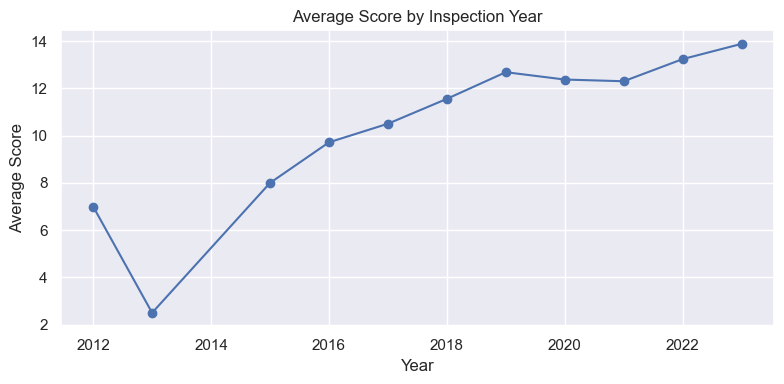

<Figure size 640x480 with 0 Axes>

In [29]:
def show_and_clear():
    plt.tight_layout()
    plt.show()
    plt.clf()

# 4.1 Grade distribution
print("\nGrade counts:")
print(df["GRADE"].value_counts())

plt.figure(figsize=(4, 4))
df["GRADE"].value_counts().loc[["A", "B", "C"]].plot(kind="bar")
plt.title("Distribution of Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
show_and_clear()

# 4.2 Score distribution
plt.figure(figsize=(6, 4))
df["SCORE"].plot(kind="hist", bins=30)
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
show_and_clear()

# 4.3 Grades by borough
print("\nGrades by BORO:")
print(pd.crosstab(df["BORO"], df["GRADE"]))

plt.figure(figsize=(8, 5))
(pd.crosstab(df["BORO"], df["GRADE"])
   .loc[:, ["A", "B", "C"]]
   .plot(kind="bar", stacked=True))
plt.title("Grades by Borough (stacked)")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
show_and_clear()

# 4.4 Top cuisines & their grades
top_cuisines = df["CUISINE DESCRIPTION"].value_counts().head(10).index

print("\nTop 10 cuisines:")
print(df["CUISINE DESCRIPTION"].value_counts().head(10))

plt.figure(figsize=(8, 6))
df[df["CUISINE DESCRIPTION"].isin(top_cuisines)]["CUISINE DESCRIPTION"] \
  .value_counts().plot(kind="barh")
plt.title("Top 10 Cuisines by Number of Inspections")
plt.xlabel("Count")
plt.ylabel("Cuisine")
show_and_clear()

plt.figure(figsize=(10, 6))
pd.crosstab(
    df.loc[df["CUISINE DESCRIPTION"].isin(top_cuisines), "CUISINE DESCRIPTION"],
    df.loc[df["CUISINE DESCRIPTION"].isin(top_cuisines), "GRADE"]
).loc[top_cuisines, ["A", "B", "C"]].plot(kind="barh", stacked=True)
plt.title("Grades for Top 10 Cuisines")
plt.xlabel("Count")
plt.ylabel("Cuisine")
show_and_clear()

# 4.5 Average score by year
yearly_scores = df.groupby("INSPECTION_YEAR")["SCORE"].mean().sort_index()
print("\nAverage SCORE by year:")
print(yearly_scores)

plt.figure(figsize=(8, 4))
yearly_scores.plot(marker="o")
plt.title("Average Score by Inspection Year")
plt.xlabel("Year")
plt.ylabel("Average Score")
show_and_clear()

## Simple Feature Engineering

In [30]:
# 4.2 HAS_VIOLATION: did the inspection find any violations?
df["HAS_VIOLATION"] = (df["SCORE"] > 0).astype(int)

# 4.3 Clean & encode CRITICAL FLAG (three states)
# Your data has three outcomes:
#   1) Critical
#   2) Not Critical
#   3) Not Applicable
# Some raw datasets also use 'Y'/'N', so normalize both possibilities.

df["CRITICAL FLAG"] = df["CRITICAL FLAG"].replace({
    "Y": "Critical",
    "N": "Not Critical",
    "Not Applicable": "Not Applicable"
})

df["CRITICAL FLAG"] = df["CRITICAL FLAG"].astype("category")

# Binary: was this inspection critical?
df["CRITICAL_BINARY"] = df["CRITICAL FLAG"].apply(
    lambda x: 1 if x == "Critical" else 0
)

# One-hot encoding for the 3 categories (Critical / Not Critical / Not Applicable)
critical_dummies = pd.get_dummies(df["CRITICAL FLAG"], prefix="CRITICAL")
df = pd.concat([df, critical_dummies], axis=1)

# 4.4 Treat a few key columns as categorical
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("\nSample after feature engineering:")
print(df.head())


Sample after feature engineering:
      CAMIS                   DBA           BORO BUILDING             STREET  \
0  41647571         PEKING GARDEN      Manhattan     3163           BROADWAY   
1  50128737           BAO BY KAYA      Manhattan      570   LEXINGTON AVENUE   
2  40510804         WOODROW DINER  Staten Island      655   ROSSVILLE AVENUE   
3  50077566        JANE FAST FOOD         Queens     8622           BROADWAY   
4  50110452  GREENHOUSE CAFE RBNY         Queens    10810  ROCKAWAY BEACH DR   

  ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0   10027  2128653600             Chinese      2022-02-01   
1   10022  9294219987  Asian/Asian Fusion      2022-11-18   
2   10309  7186054031            American      2020-03-05   
3   11373  6463066186             Chinese      2020-02-21   
4   11694  7184898938          Coffee/Tea      2021-12-01   

                                              ACTION  ...      BIN  \
0    Violations were cited in the following are

## Correlation Checks


=== Cramér’s V (categorical vs GRADE) ===
BORO: 0.0302
CUISINE DESCRIPTION: 0.1514
INSPECTION TYPE: 0.3738
CRITICAL FLAG: 0.0961

=== Numeric feature differentiation across grades (Kruskal–Wallis) ===
SCORE: p=0.000000e+00
Latitude: p=5.342427e-02
Longitude: p=1.417974e-23


<Figure size 600x400 with 0 Axes>

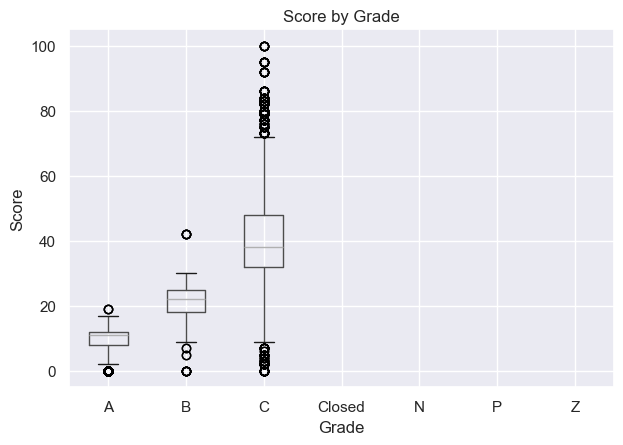

In [31]:
def cramers_v(x, y):
    """Cramér’s V for categorical-categorical association."""
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2_corr = max(0, phi2 - (k - 1)*(r - 1) / (n - 1))
    r_corr = r - (r - 1)**2 / (n - 1)
    k_corr = k - (k - 1)**2 / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

print("\n=== Cramér’s V (categorical vs GRADE) ===")
cat_for_corr = ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE", "CRITICAL FLAG"]
for col in cat_for_corr:
    val = cramers_v(df[col], df["GRADE"])
    print(f"{col}: {val:.4f}")

print("\n=== Numeric feature differentiation across grades (Kruskal–Wallis) ===")
def grade_groups(col):
    return (
        df[df["GRADE"] == "A"][col],
        df[df["GRADE"] == "B"][col],
        df[df["GRADE"] == "C"][col],
    )

for num_col in ["SCORE", "Latitude", "Longitude"]:
    if num_col in df.columns:
        A, B, C = grade_groups(num_col)
        stat, p = kruskal(A, B, C)
        print(f"{num_col}: p={p:.6e}")

# Optional simple plot: score distribution by grade
plt.figure(figsize=(6, 4))
df.boxplot(column="SCORE", by="GRADE")
plt.title("Score by Grade")
plt.suptitle("")
plt.xlabel("Grade")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


## Feature Matrix for Modeling

In [32]:
# --- Pre-inspection features only ---
feature_cols = [
    "Latitude",
    "Longitude",
    "BORO",
    "CUISINE DESCRIPTION",
    "INSPECTION_YEAR",
    "INSPECTION_MONTH",
]

X = df[feature_cols].copy()
y = df["GRADE"].copy()
groups = df["CAMIS"]  # still needed for grouped splitting

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique restaurants:", groups.nunique())

X shape: (83603, 6)
y shape: (83603,)
Unique restaurants: 21165


## Grouped 70/30 Train-test Split

In [33]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (58336, 6)
Test size: (25267, 6)


## Preprocessing for Categorical Variables

In [34]:
categorical_cols = ["BORO", "CUISINE DESCRIPTION"]
numeric_cols = ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

## Baseline Random Forest Classifier

In [47]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model),
])

pipeline.fit(X_train, y_train)

def classification_report_df(y_true, y_pred):
    """Convert sklearn classification_report to pandas DataFrame."""
    report = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame(report).transpose()

def confusion_matrix_df(y_true, y_pred, labels=["A","B","C"]):
    """Return a labeled confusion matrix DataFrame."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return pd.DataFrame(cm, index=[f"True {l}" for l in labels],
                           columns=[f"Pred {l}" for l in labels])

# --- TRAIN EVAL ---
y_train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Random Forest Classifier TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)
train_cm_df = confusion_matrix_df(y_train, y_train_pred)

print("\n=== Random Forest Classifier TRAIN REPORT ===")
display(train_report_df)

print("\n=== Random Forest Classifier TRAIN CONFUSION MATRIX ===")
display(train_cm_df)


# --- TEST EVAL ---
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("=== Random Forest Classifier TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)
test_cm_df = confusion_matrix_df(y_test, y_test_pred)

print("\n=== Random Forest Classifier TEST CLASSIFICATION REPORT ===")
display(test_report_df)

print("\n=== Random Forest Classifier TEST CONFUSION MATRIX ===")
display(test_cm_df)


=== Random Forest Classifier TRAIN ACCURACY === 0.9994685957213385

=== Random Forest Classifier TRAIN REPORT ===


,precision,recall,f1-score,support
A,1.000000,0.999352,0.999676,47816.000000
B,0.996805,1.000000,0.998400,6863.000000
C,0.997545,1.000000,0.998771,3657.000000
accuracy,0.999469,0.999469,0.999469,0.999469
macro avg,0.998117,0.999784,0.998949,58336.000000
weighted avg,0.999470,0.999469,0.999469,58336.000000



=== Random Forest Classifier TRAIN CONFUSION MATRIX ===


,Pred A,Pred B,Pred C
True A,47785,22,9
True B,0,6863,0
True C,0,0,3657


=== Random Forest Classifier TEST ACCURACY === 0.8011239957256501

=== Random Forest Classifier TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.820082,0.973113,0.890068,20605.000000
B,0.231270,0.045674,0.076283,3109.000000
C,0.241379,0.031552,0.055809,1553.000000
accuracy,0.801124,0.801124,0.801124,0.801124
macro avg,0.430910,0.350113,0.340720,25267.000000
weighted avg,0.712062,0.801124,0.738658,25267.000000



=== Random Forest Classifier TEST CONFUSION MATRIX ===


,Pred A,Pred B,Pred C
True A,20051,438,116
True B,2929,142,38
True C,1470,34,49


## XGBoost Model

In [37]:
# -----------------------------
# 1. Encode labels A/B/C → 0/1/2
# -----------------------------
label_to_int = {"A": 0, "B": 1, "C": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_enc = y_train.map(label_to_int)
y_test_enc  = y_test.map(label_to_int)

# -----------------------------
# 2. Compute sample weights to handle class imbalance
#    (still based on original labels, that's fine)
# -----------------------------
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# -----------------------------
# 3. Define XGBoost classifier
# -----------------------------
xgb_clf = XGBClassifier(
    objective="multi:softprob",   # probabilistic multi-class
    eval_metric="mlogloss",
    num_class=3,                  # 3 grades: A, B, C
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# 4. Build pipeline: preprocess → model
# -----------------------------
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_clf),
])

# -----------------------------
# 5. Train with encoded labels
# -----------------------------
xgb_pipeline.fit(
    X_train,
    y_train_enc,
    model__sample_weight=sample_weights
)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred_enc = xgb_pipeline.predict(X_train)
# convert back to A/B/C for reporting
y_train_pred = pd.Series(y_train_pred_enc).map(int_to_label)

train_acc = accuracy_score(y_train, y_train_pred)
print("=== XGBoost TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)
train_cm_df = confusion_matrix_df(y_train, y_train_pred)

print("\n=== XGBoost TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

print("\n=== XGBoost TRAIN CONFUSION MATRIX ===")
display(train_cm_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred_enc = xgb_pipeline.predict(X_test)
y_test_pred = pd.Series(y_test_pred_enc).map(int_to_label)

test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== XGBoost TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)
test_cm_df = confusion_matrix_df(y_test, y_test_pred)

print("\n=== XGBoost TEST CLASSIFICATION REPORT ===")
display(test_report_df)

print("\n=== XGBoost TEST CONFUSION MATRIX ===")
display(test_cm_df)


=== XGBoost TRAIN ACCURACY === 0.6747805814591333

=== XGBoost TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.949277,0.660281,0.778834,47816.000000
B,0.316339,0.697071,0.435186,6863.000000
C,0.302190,0.822532,0.441995,3657.000000
accuracy,0.674781,0.674781,0.674781,0.674781
macro avg,0.522602,0.726628,0.552005,58336.000000
weighted avg,0.834249,0.674781,0.717290,58336.000000



=== XGBoost TRAIN CONFUSION MATRIX ===


,Pred A,Pred B,Pred C
True A,31572,10122,6122
True B,1255,4784,824
True C,432,217,3008



=== XGBoost TEST ACCURACY === 0.5773934380812918

=== XGBoost TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.890327,0.624460,0.734062,20605.000000
B,0.199529,0.436153,0.273801,3109.000000
C,0.091067,0.235673,0.131371,1553.000000
accuracy,0.577393,0.577393,0.577393,0.577393
macro avg,0.393641,0.432095,0.379745,25267.000000
weighted avg,0.756202,0.577393,0.640385,25267.000000



=== XGBoost TEST CONFUSION MATRIX ===


,Pred A,Pred B,Pred C
True A,12867,4852,2886
True B,986,1356,767
True C,599,588,366


## Confusion Matrix Heatmaps

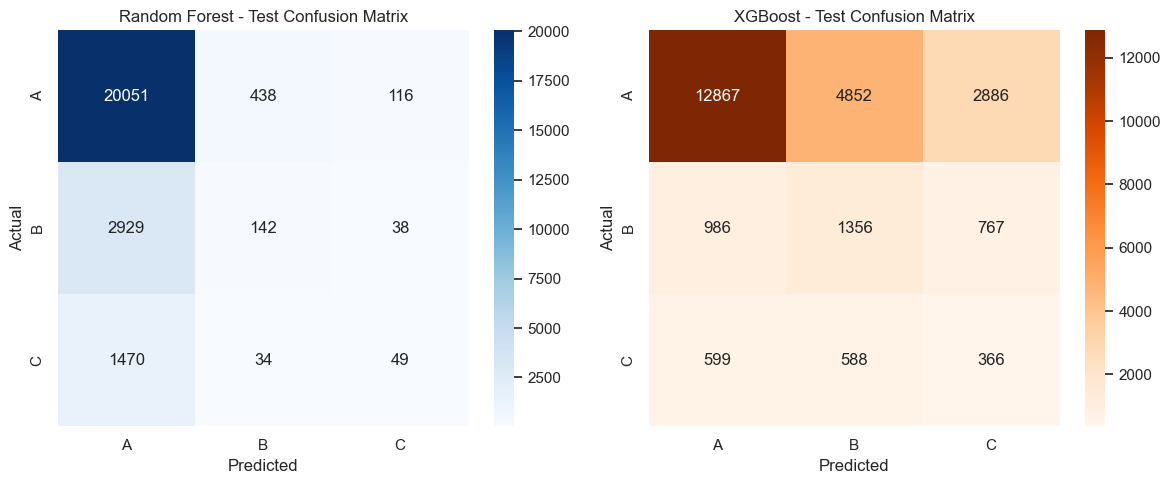

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest confusion matrix
rf_cm = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0])
axes[0].set_title("Random Forest - Test Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# XGBoost confusion matrix
xgb_preds = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_cm = confusion_matrix(y_test, xgb_preds, labels=["A", "B", "C"])
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1])
axes[1].set_title("XGBoost - Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Feature Importance

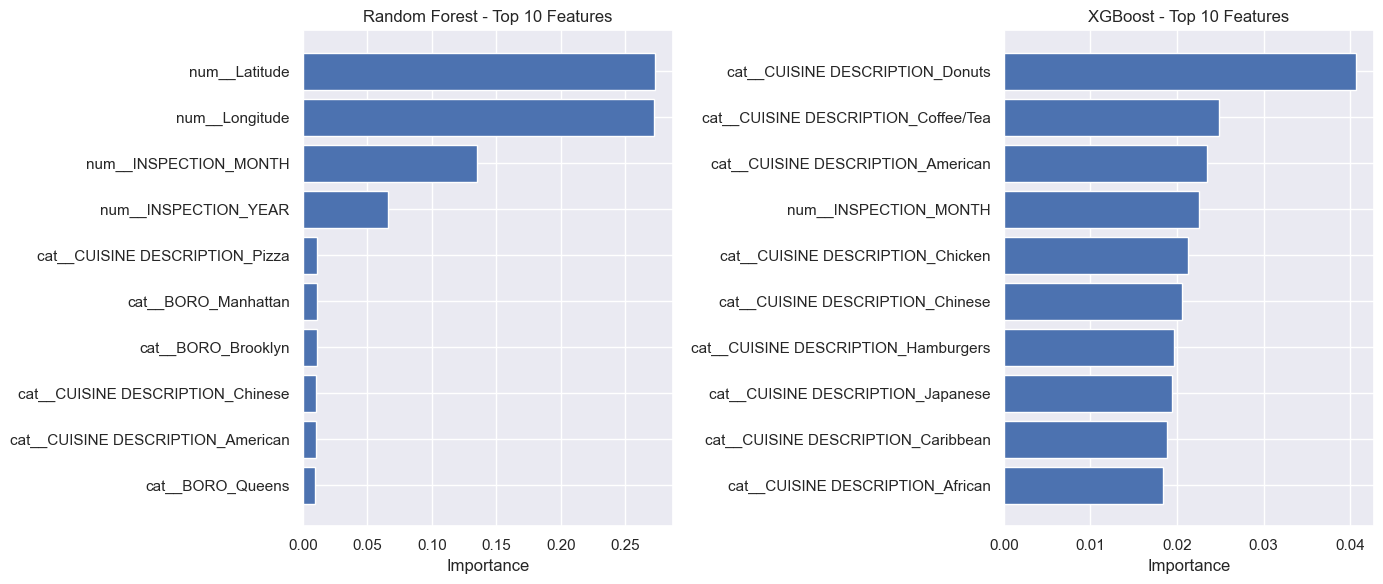

In [39]:
# Feature Importance Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get feature names from the preprocessor
feature_names = preprocess.get_feature_names_out()

# Random Forest feature importance
rf_importances = pipeline.named_steps["model"].feature_importances_
rf_top_idx = rf_importances.argsort()[-10:][::-1]
axes[0].barh(range(10), rf_importances[rf_top_idx][::-1])
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([feature_names[i] for i in rf_top_idx][::-1])
axes[0].set_xlabel("Importance")
axes[0].set_title("Random Forest - Top 10 Features")

# XGBoost feature importance
xgb_importances = xgb_pipeline.named_steps["model"].feature_importances_
xgb_top_idx = xgb_importances.argsort()[-10:][::-1]
axes[1].barh(range(10), xgb_importances[xgb_top_idx][::-1])
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([feature_names[i] for i in xgb_top_idx][::-1])
axes[1].set_xlabel("Importance")
axes[1].set_title("XGBoost - Top 10 Features")

plt.tight_layout()
plt.show()

## Class Distribution

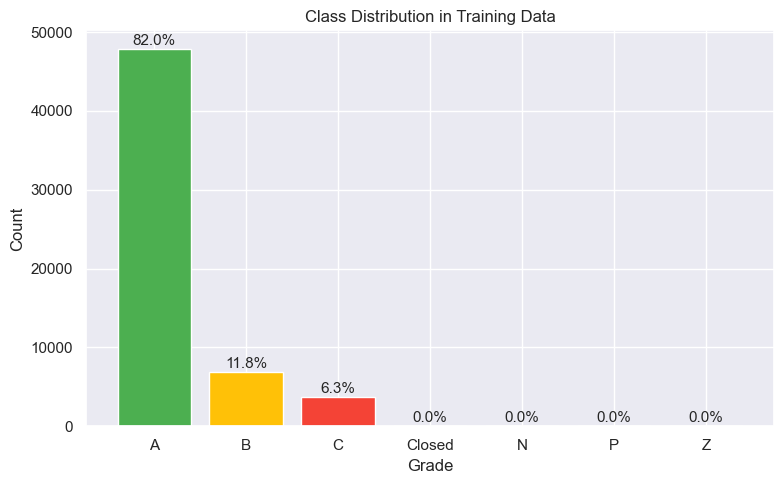

In [40]:
# Class Distribution
fig, ax = plt.subplots(figsize=(8, 5))

grade_counts = y_train.value_counts().sort_index()
colors = ["#4CAF50", "#FFC107", "#F44336"]  # Green, Yellow, Red for A, B, C

bars = ax.bar(grade_counts.index, grade_counts.values, color=colors)
ax.set_xlabel("Grade")
ax.set_ylabel("Count")
ax.set_title("Class Distribution in Training Data")

# Add percentage labels on bars
total = grade_counts.sum()
for bar, count in zip(bars, grade_counts.values):
    pct = count / total * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f"{pct:.1f}%", ha="center", fontsize=11)

plt.tight_layout()
plt.show()

## Summary Dashboard

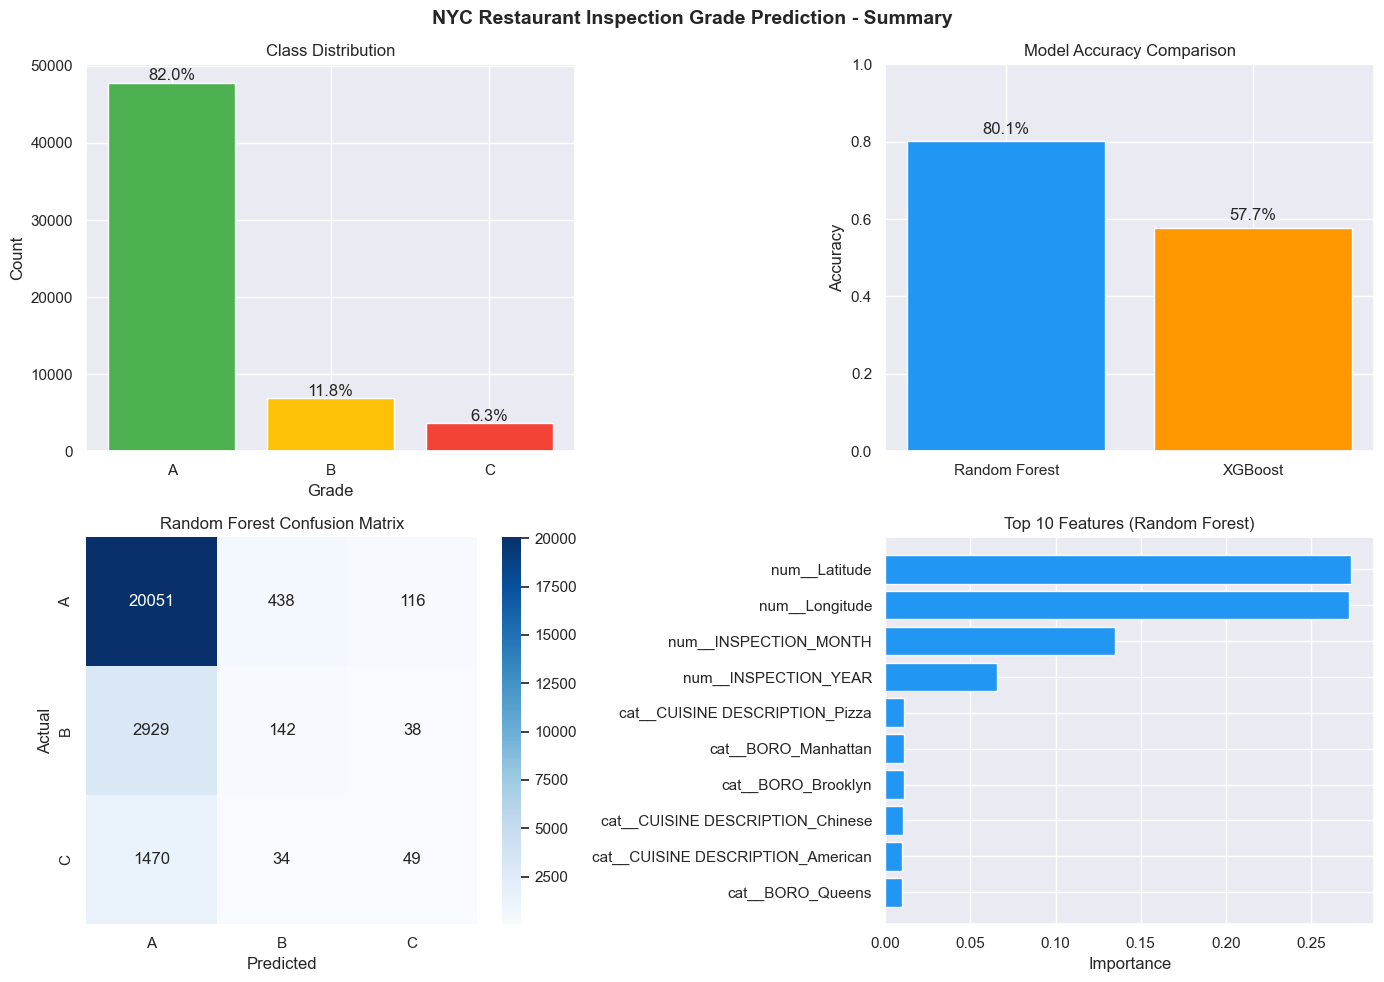

In [41]:
# Executive Summary Dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class Distribution (top left)
grade_counts = y_train.value_counts().sort_index()
colors = ["#4CAF50", "#FFC107", "#F44336"]
bars = axes[0, 0].bar(["A", "B", "C"], [grade_counts["A"], grade_counts["B"], grade_counts["C"]], color=colors)
axes[0, 0].set_title("Class Distribution")
axes[0, 0].set_xlabel("Grade")
axes[0, 0].set_ylabel("Count")
total = grade_counts.sum()
for bar, grade in zip(bars, ["A", "B", "C"]):
    pct = grade_counts[grade] / total * 100
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300, f"{pct:.1f}%", ha="center")

# 2. Model Comparison (top right)
models = ["Random Forest", "XGBoost"]
rf_acc = accuracy_score(y_test, pipeline.predict(X_test))
xgb_preds = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_acc = accuracy_score(y_test, xgb_preds)
axes[0, 1].bar(models, [rf_acc, xgb_acc], color=["#2196F3", "#FF9800"])
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_title("Model Accuracy Comparison")
axes[0, 1].set_ylabel("Accuracy")
for i, acc in enumerate([rf_acc, xgb_acc]):
    axes[0, 1].text(i, acc + 0.02, f"{acc:.1%}", ha="center")

# 3. Best Model Confusion Matrix (bottom left)
rf_cm = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 0])
axes[1, 0].set_title("Random Forest Confusion Matrix")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

# 4. Top 10 Features (bottom right)
feature_names = preprocess.get_feature_names_out()
rf_importances = pipeline.named_steps["model"].feature_importances_
top_idx = rf_importances.argsort()[-10:][::-1]
axes[1, 1].barh(range(10), rf_importances[top_idx][::-1], color="#2196F3")
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels([feature_names[i] for i in top_idx][::-1])
axes[1, 1].set_title("Top 10 Features (Random Forest)")
axes[1, 1].set_xlabel("Importance")

plt.suptitle("NYC Restaurant Inspection Grade Prediction - Summary", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Geographic Distribution

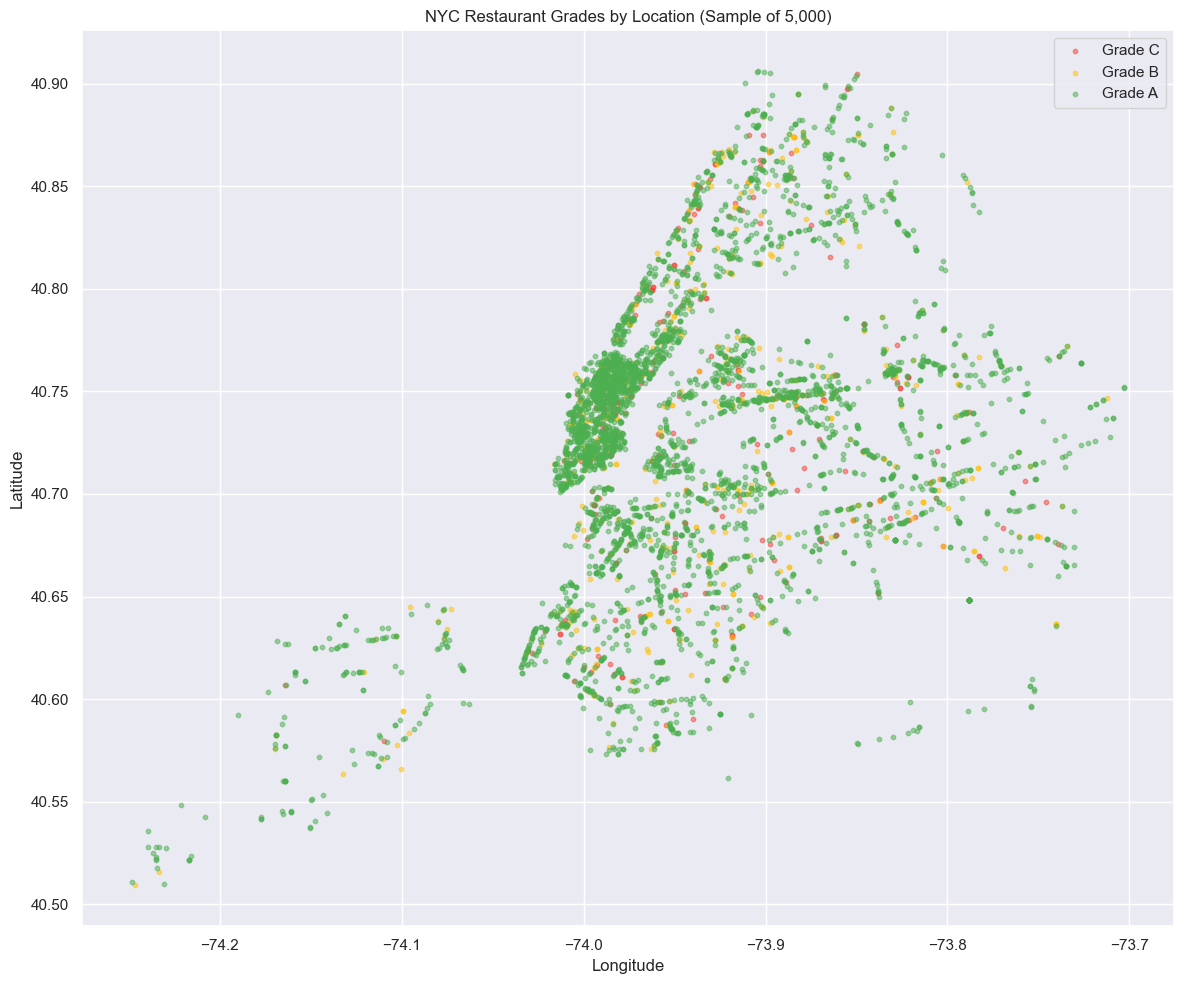

In [42]:
# Geographic Distribution of Grades
fig, ax = plt.subplots(figsize=(12, 10))

# Sample for performance (plotting 80k+ points is slow)
sample_df = df.sample(n=5000, random_state=42)

colors_map = {"A": "#4CAF50", "B": "#FFC107", "C": "#F44336"}
for grade in ["C", "B", "A"]:  # Plot A last so it doesn't cover the others
    subset = sample_df[sample_df["GRADE"] == grade]
    ax.scatter(subset["Longitude"], subset["Latitude"], 
               c=colors_map[grade], label=f"Grade {grade}", alpha=0.5, s=10)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NYC Restaurant Grades by Location (Sample of 5,000)")
ax.legend()
plt.tight_layout()
plt.show()

## Model Performance Comparison

=== MODEL PERFORMANCE COMPARISON (TEST SET) ===



,Random Forest,XGBoost,Winner
Accuracy,0.8011,0.5774,Random Forest
Precision,0.7121,0.7562,XGBoost
Recall,0.8011,0.5774,Random Forest
F1-Score,0.7387,0.6404,Random Forest


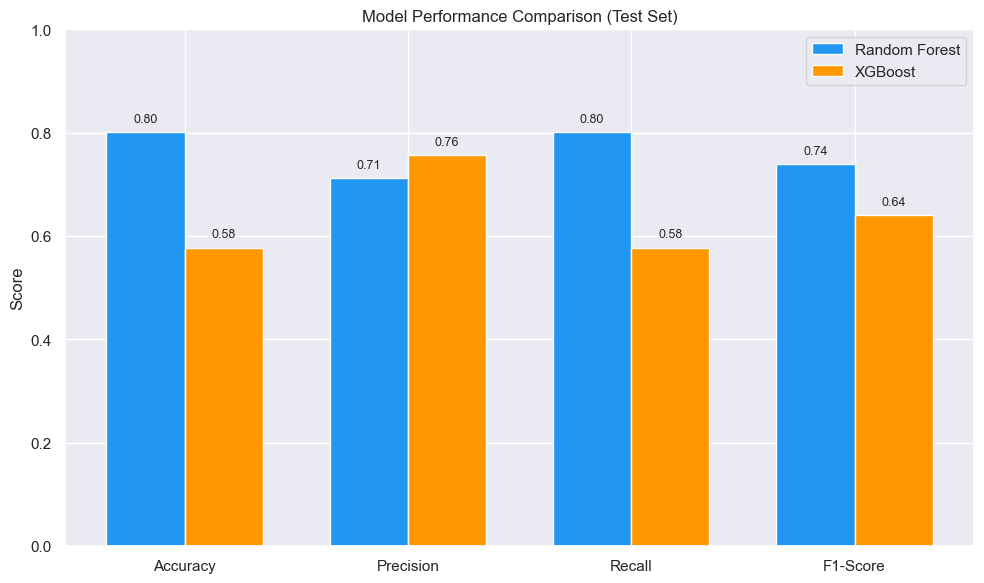

In [43]:
# Model Metrics Comparison
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions
rf_preds = pipeline.predict(X_test)
xgb_preds_encoded = xgb_pipeline.predict(X_test)
xgb_preds = pd.Series(xgb_preds_encoded).map({0: "A", 1: "B", 2: "C"})

# Calculate metrics (weighted average to handle imbalance)
metrics = {
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds)
    ],
    "Precision": [
        precision_score(y_test, rf_preds, average="weighted"),
        precision_score(y_test, xgb_preds, average="weighted")
    ],
    "Recall": [
        recall_score(y_test, rf_preds, average="weighted"),
        recall_score(y_test, xgb_preds, average="weighted")
    ],
    "F1-Score": [
        f1_score(y_test, rf_preds, average="weighted"),
        f1_score(y_test, xgb_preds, average="weighted")
    ]
}

# Create summary table
summary_df = pd.DataFrame(metrics, index=["Random Forest", "XGBoost"]).T
summary_df["Winner"] = summary_df.apply(lambda row: "Random Forest" if row["Random Forest"] > row["XGBoost"] else "XGBoost", axis=1)
print("=== MODEL PERFORMANCE COMPARISON (TEST SET) ===\n")
display(summary_df.round(4))

# Plot
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [metrics[m][0] for m in metrics], width, label="Random Forest", color="#2196F3")
bars2 = ax.bar(x + width/2, [metrics[m][1] for m in metrics], width, label="XGBoost", color="#FF9800")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison (Test Set)")
ax.set_xticks(x)
ax.set_xticklabels(metrics.keys())
ax.set_ylim(0, 1)
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha="center", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()